Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

Validation Accuracy: 0.9912
Validation Precision: 0.9914
Validation Recall: 0.9912
Validation F1 Score: 0.9913


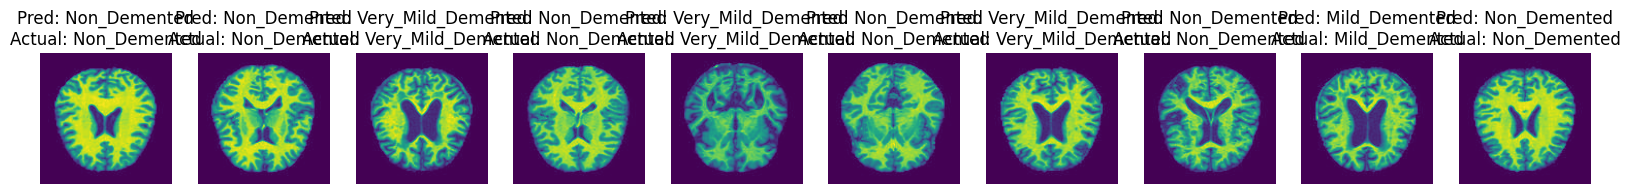

In [39]:
import torch
from transformers import AutoModelForImageClassification, AutoImageProcessor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load the validation dataset
dataset = load_dataset("Falah/Alzheimer_MRI")
dataset = dataset['train'].train_test_split(test_size=0.2)  # 80% train, 20% validation
val_dataset = dataset['test']

# Load the image processor and the trained model
model_path = "/home/dev/synth/projects/beagle_security-intern_test/src/alz_model"
processor = AutoImageProcessor.from_pretrained("google/efficientnet-b0")
model = AutoModelForImageClassification.from_pretrained(model_path)

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Preprocessing function consistent with training
def preprocess_images(examples):
    images = [np.array(image) for image in examples["image"]]
    
    # Convert grayscale to RGB by repeating the single channel 3 times
    images = [np.repeat(image[:, :, np.newaxis], 3, axis=2) for image in images]
    
    inputs = processor(images=images, return_tensors="pt")
    inputs['labels'] = examples['label']
    return inputs

# Apply preprocessing to the validation dataset
val_dataset = val_dataset.map(preprocess_images, batched=True)

# Define a custom Dataset class for preprocessing
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['pixel_values']
        label = item['labels']
        return {
            'pixel_values': torch.tensor(image),
            'labels': torch.tensor(label),
            'image': np.array(item['image'])  # Save the original image for later display
        }

# Create a DataLoader for the validation dataset
val_dataset = CustomDataset(val_dataset)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Define the evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    preds = []
    labels = []
    images = []
    
    for batch in dataloader:
        pixel_values = batch['pixel_values'].to(device)
        labels_batch = batch['labels']
        labels.extend(labels_batch.cpu().numpy())
        images.extend(batch['image'])  # Assuming 'image' is a list of images for display
        
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'images': images,  # Assuming you want to return images for display
        'preds': preds,
        'labels': labels
    }
# Evaluate the model
evaluation_results = evaluate_model(model, val_dataloader)

# Print evaluation metrics
print(f"Validation Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"Validation Precision: {evaluation_results['precision']:.4f}")
print(f"Validation Recall: {evaluation_results['recall']:.4f}")
print(f"Validation F1 Score: {evaluation_results['f1']:.4f}")

# Display images with predicted and actual labels
def show_images(images, preds, labels, id2label, num_images=10):
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        image = images[i]
        plt.imshow(image)
        plt.title(f"Pred: {id2label[preds[i]]}\nActual: {id2label[labels[i]]}")
        plt.axis('off')
    plt.show()

# Get the id2label dictionary
id2label = model.config.id2label

# Show images
show_images(evaluation_results['images'], evaluation_results['preds'], evaluation_results['labels'], id2label, num_images=10)